[*********************100%***********************]  19 of 19 completed


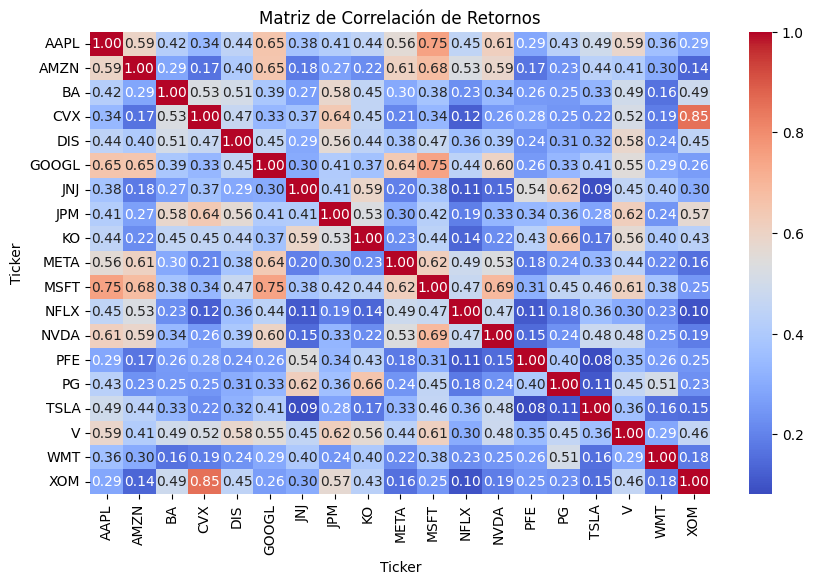

Número óptimo de clusters: 2


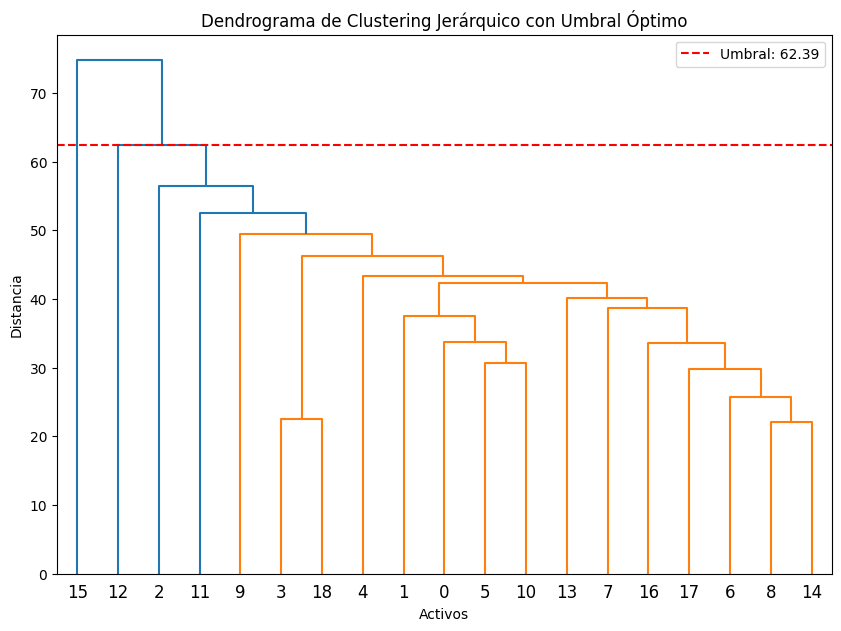

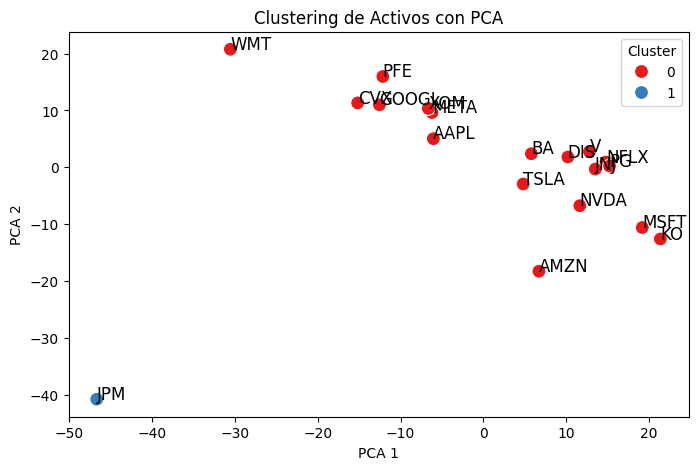

Activos Seleccionados para la Optimización de Portafolio: ['AAPL' 'JPM']


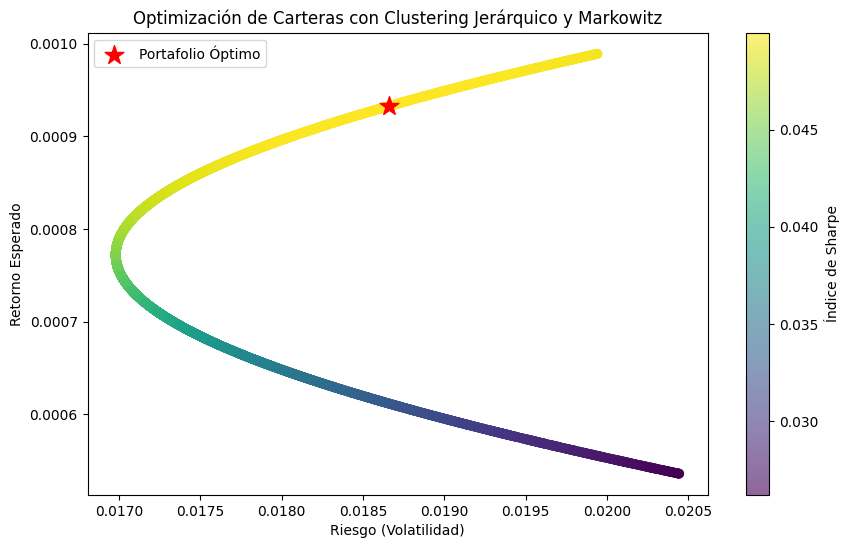

Pesos del portafolio óptimo basado en clustering jerárquico y Markowitz:
AAPL: 87.54%
JPM: 12.46%
Retorno Esperado del Portafolio Óptimo: 0.09%
Retorno Esperado Anual del Portafolio Óptimo: 23.51%
Volatilidad del Portafolio Óptimo: 1.87%
Volatilidad Anual del Portafolio Óptimo: 29.63%


In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 1. Cargar datos financieros
TICKERS = [
    'AAPL',  # Tecnología: Apple
    'GOOGL',  # Tecnología: Alphabet (Google)
    'AMZN',  # Consumo: Amazon
    'MSFT',  # Tecnología: Microsoft
    'TSLA',  # Automotriz: Tesla
    'META',  # Tecnología: Meta (Facebook)
    'NFLX',  # Entretenimiento: Netflix
    'NVDA',  # Tecnología: NVIDIA
    'JNJ',   # Salud: Johnson & Johnson
    'PFE',   # Salud: Pfizer
    'XOM',   # Energía: ExxonMobil
    'CVX',   # Energía: Chevron
    'WMT',   # Consumo: Walmart
    'PG',    # Consumo: Procter & Gamble
    'V',     # Finanzas: Visa
    'JPM',   # Finanzas: JPMorgan Chase
    'BA',    # Industria: Boeing
    'DIS',   # Entretenimiento: Walt Disney
    'KO'     # Consumo: Coca-Cola
]
data = yf.download(TICKERS, start="2020-01-01", end="2024-12-31")['Close']

# 2. Calcular Retornos Logarítmicos
returns = np.log(data / data.shift(1)).dropna()

# 3. Visualizar la Correlación entre Activos
plt.figure(figsize=(10,6))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación de Retornos")
plt.show()

# 4. Normalizar los datos para Clustering
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.T)

# 5. Generar el linkage
Z = linkage(returns_scaled, method='average')  # Usamos 'average' para el linkage

# 6. Calcular el número óptimo de clusters basado en el "codo" del dendrograma
# Podemos observar la distancia entre fusiones y encontrar el punto donde esta aumenta bruscamente.
# Usamos np.diff para encontrar las diferencias en distancias entre fusiones consecutivas
distances = Z[:, 2]
diff_distances = np.diff(distances)

# Encontramos el "codo", el punto de mayor diferencia
threshold_index = np.argmax(diff_distances)  # El índice donde la diferencia es mayor
optimal_threshold = distances[threshold_index]  # La distancia en ese punto

# Usamos fcluster para obtener los clusters según el umbral óptimo
clusters = fcluster(Z, optimal_threshold, criterion='distance')

# El número de clusters (optimal_k) es simplemente el número de valores únicos en los clusters
optimal_k = len(set(clusters))

# Imprimir el número óptimo de clusters
print(f"Número óptimo de clusters: {optimal_k}")

# 7. Graficar el Dendrograma con el umbral óptimo
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.axhline(y=optimal_threshold, color='r', linestyle='--', label=f'Umbral: {optimal_threshold:.2f}')
plt.title("Dendrograma de Clustering Jerárquico con Umbral Óptimo")
plt.xlabel("Activos")
plt.ylabel("Distancia")
plt.legend()
plt.show()

# 8. Aplicar Clustering Jerárquico (AgglomerativeClustering) con el número óptimo de clusters
agg_clust = AgglomerativeClustering(n_clusters=optimal_k, linkage='average')  # Sin el parámetro 'affinity'
labels = agg_clust.fit_predict(returns_scaled)

# 9. Visualizar Clusters con PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(returns_scaled)

plt.figure(figsize=(8,5))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels, palette='Set1', s=100)
for i, ticker in enumerate(TICKERS):
    plt.text(pca_result[i,0], pca_result[i,1], ticker, fontsize=12)
plt.title("Clustering de Activos con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

# 10. Seleccionar un Activo Representante de cada Cluster
cluster_df = pd.DataFrame({'Ticker': TICKERS, 'Cluster': labels})
selected_assets = cluster_df.groupby('Cluster').first()['Ticker'].values
print("Activos Seleccionados para la Optimización de Portafolio:", selected_assets)

# 11. Optimización de Carteras con Markowitz
returns_selected = returns[selected_assets]
mean_returns = returns_selected.mean()
cov_matrix = returns_selected.cov()
num_portfolios = 10000

results = np.zeros((3, num_portfolios))
weights_record = np.zeros((num_portfolios, len(selected_assets)))

for i in range(num_portfolios):
    weights = np.random.random(len(selected_assets))
    weights /= np.sum(weights)
    weights_record[i, :] = weights
    port_return = np.sum(weights * mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = port_return / port_volatility if port_volatility != 0 else 0
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe_ratio

# Encontrar el portafolio óptimo según Sharpe Ratio
max_sharpe_idx = np.argmax(results[2, :])
optimal_weights = weights_record[max_sharpe_idx, :]

# 12. Visualizar la Frontera Eficiente
plt.figure(figsize=(10,6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.6)
plt.colorbar(label='Índice de Sharpe')
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], color='red', marker='*', s=200, label='Portafolio Óptimo')
plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Retorno Esperado')
plt.legend()
plt.title('Optimización de Carteras con Clustering Jerárquico y Markowitz')
plt.show()

# 13. Mostrar los Pesos del Portafolio Óptimo
print("Pesos del portafolio óptimo basado en clustering jerárquico y Markowitz:")   
for asset, weight in zip(selected_assets, optimal_weights):
    print(f"{asset}: {weight:.2%}")

# 14. Calcular el Retorno y Volatilidad del Portafolio Óptimo
portfolio_return = np.sum(optimal_weights * mean_returns)  
print(f"Retorno Esperado del Portafolio Óptimo: {portfolio_return:.2%}")

# Anualizar el retorno del portafolio óptimo
portfolio_return_annual = portfolio_return * 252  # 252 días de trading por año
print(f"Retorno Esperado Anual del Portafolio Óptimo: {portfolio_return_annual:.2%}")

# Calcular la volatilidad del portafolio óptimo
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))  
print(f"Volatilidad del Portafolio Óptimo: {portfolio_volatility:.2%}")

# Anualizar la volatilidad del portafolio óptimo
portfolio_volatility_annual = portfolio_volatility * np.sqrt(252)  # 252 días de trading por año
print(f"Volatilidad Anual del Portafolio Óptimo: {portfolio_volatility_annual:.2%}")